<a href="https://colab.research.google.com/github/plaban1981/NLP/blob/master/Seq2Seq_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!unzip '/content/drive/My Drive/Zindi/fra-eng.zip'

Archive:  /content/drive/My Drive/Zindi/fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [27]:
# read txtfile into a list line by line :
with open('fra.txt', 'r', encoding='utf-8-sig') as f:
    text = f.readlines()

In [28]:
text[3].split('\t')

['Run!',
 'Cours\u202f!',
 'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)\n']

In [11]:
# Define impty lists to store the samples in them:
en_samples = []
de_samples = []

# Define impty sets to store the characters in them:
en_chars = set()
de_chars = set()

# Split the samples and get the character sets :
for line in text:
    en_ , de_,_ = line.split('\t')
    de_ = '\t' + de_
    for char in de_:
        if char not in de_chars:
            de_chars.add(char)
    for char in en_:
        if char not in en_chars:
            en_chars.add(char)
    en_samples.append(en_)
    de_samples.append(de_)
   
# Add the chars \t and \n to the sets 
de_chars.add('\n')
de_chars.add('\t')

en_chars.add('\n')
en_chars.add('\t')    


In [16]:
en_samples[:3],de_samples[:3]

(['Go.', 'Hi.', 'Hi.'], ['\tVa !', '\tSalut !', '\tSalut.'])

* E → the input text ( Will be encoded later )
* D → the output text ( Will be decoded later )

In [24]:
print(f'number of E samples {len(en_samples)}')
print(f'number of D samples {len(de_samples)}')
print(f'number of E chars {len(en_chars)}')
print(f'number of D chars {len(de_chars)}')
print(f'Longest E sample has {max([len(x) for x in en_samples])} characters')
print(f'Longest D sample has {max([len(x) for x in de_samples])} characters')

number of E samples 177210
number of D samples 177210
number of E chars 92
number of D chars 115
Longest E sample has 262 characters
Longest D sample has 326 characters


In [29]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [30]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

## Data Preprocessing

The **English sentence is inserted into the input_sentences[] list**. 

The substring to the right of the tab is the corresponding **translated French sentence is inserted into variable output**. 

The <eos> token, which marks the end-of-sentence is prefixed to the translated sentence, and the resultant sentence is appended to the output_sentences[] list. 

Similarly, the <sos> token, which stands for "start of sentence", is concatenated at the start of the translated sentence and the result is added to the output_sentences_inputs[] list. 

*The loop terminates if the number of sentences added to the lists is greater than the NUM_SENTENCES variable, 
i.e. 20,000.*

In [33]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open(r'/content/fra.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence, output,_ = line.rstrip().split('\t')

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 20000
num samples output: 20000
num samples output input: 20000


In [35]:
input_sentences[0],output_sentences[0],output_sentences_inputs[0]

('Go.', 'Va ! <eos>', '<sos> Va !')

Randomly print a sentence from the input_sentences[], output_sentences[], and output_sentences_inputs[] lists:

In [36]:
print(input_sentences[172]) # input language 
print(output_sentences[172]) # translated French sentence as output
print(output_sentences_inputs[172]) # input to the decoder

I'm hit!
Je suis touchée ! <eos>
<sos> Je suis touchée !


In [38]:
print(input_sentences[200]) # input language 
print(output_sentences[200]) # translated French sentence as output
print(output_sentences_inputs[200]) # input to the decoder

Skip it.
Pas grave. <eos>
<sos> Pas grave.


## Tokenization and Pading

For tokenization, the Tokenizer class from the keras.preprocessing.text library can be used. The tokenizer class performs two tasks:

* It divides a sentence into the corresponding list of word
* Then it converts the words to integers

In [39]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 3501
Length of longest sentence in input: 6


The word_index attribute of the Tokenizer class returns a word-to-index dictionary where words are the keys and the corresponding integers are the values

In [40]:
word2idx_inputs

{'i': 1,
 'you': 2,
 'a': 3,
 'it': 4,
 "i'm": 5,
 'is': 6,
 'he': 7,
 'tom': 8,
 "you're": 9,
 'the': 10,
 'are': 11,
 'me': 12,
 'we': 13,
 'was': 14,
 'this': 15,
 'to': 16,
 'do': 17,
 'that': 18,
 "it's": 19,
 'go': 20,
 'have': 21,
 "don't": 22,
 'not': 23,
 'your': 24,
 'my': 25,
 "we're": 26,
 'be': 27,
 'can': 28,
 'no': 29,
 'did': 30,
 'they': 31,
 'all': 32,
 'like': 33,
 'she': 34,
 "i'll": 35,
 'here': 36,
 'need': 37,
 'in': 38,
 'up': 39,
 'love': 40,
 'him': 41,
 'on': 42,
 'what': 43,
 "that's": 44,
 'very': 45,
 'get': 46,
 'how': 47,
 'want': 48,
 "he's": 49,
 'come': 50,
 'one': 51,
 "can't": 52,
 'got': 53,
 'so': 54,
 'am': 55,
 "they're": 56,
 'now': 57,
 'out': 58,
 'us': 59,
 'let': 60,
 'know': 61,
 'just': 62,
 'too': 63,
 'stop': 64,
 'look': 65,
 'see': 66,
 'who': 67,
 'please': 68,
 'feel': 69,
 'good': 70,
 'will': 71,
 'there': 72,
 'had': 73,
 'help': 74,
 'home': 75,
 'happy': 76,
 'try': 77,
 'for': 78,
 'give': 79,
 'must': 80,
 'hate': 81,
 'at': 

In [41]:
input_integer_seq

[[20],
 [854],
 [854],
 [191],
 [191],
 [67],
 [2434],
 [609],
 [74],
 [777],
 [64],
 [64],
 [64],
 [110],
 [110],
 [20, 42],
 [20, 42],
 [20, 42],
 [855],
 [855],
 [1, 66],
 [1, 77],
 [1, 227],
 [1, 227],
 [1, 227],
 [778, 29],
 [953],
 [953],
 [1211],
 [1211],
 [1211],
 [1211],
 [46, 39],
 [20, 57],
 [20, 57],
 [20, 57],
 [53, 4],
 [53, 4],
 [53, 4],
 [53, 4],
 [53, 4],
 [1782, 38],
 [1782, 38],
 [514, 12],
 [514, 12],
 [1, 414],
 [1, 414],
 [1, 61],
 [1, 140],
 [1, 140],
 [1, 403],
 [1, 100],
 [1, 389],
 [5, 1783],
 [5, 157],
 [5, 157],
 [485],
 [29, 198],
 [29, 198],
 [29, 198],
 [29, 198],
 [29, 198],
 [29, 198],
 [29, 198],
 [29, 198],
 [29, 198],
 [148],
 [148],
 [148],
 [360],
 [13, 77],
 [13, 227],
 [13, 227],
 [13, 227],
 [13, 227],
 [159, 8],
 [340],
 [27, 341],
 [27, 341],
 [27, 341],
 [27, 237],
 [27, 404],
 [27, 404],
 [27, 404],
 [27, 404],
 [27, 404],
 [27, 404],
 [27, 415],
 [27, 111],
 [27, 111],
 [27, 111],
 [27, 111],
 [27, 111],
 [27, 111],
 [856, 4],
 [161, 12],
 

## Tokenize Output Sequences

In [74]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 9511
Length of longest sentence in the output: 12


In [42]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS,filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

In [43]:
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

Total unique words in the output: 9511


In [44]:
num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Length of longest sentence in the output: 12


In [75]:
num_words_output

9512

# Padding 
The reason behind padding the input and the output is that text sentences can be of varying length, however LSTM  expects input instances with the same length. Therefore, we need to convert our sentences into fixed-length vectors. One way to do this is via padding.

In padding, a certain length is defined for a sentence. In our case the length of the longest sentence in the inputs and outputs will be used for padding the input and output sentences, respectively. The longest sentence in the input contains 6 words. For the sentences that contain less than 6 words, zeros will be added in the empty indexes. The following script applies padding to the input sentences.

In [48]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("input text : ",input_sentences[172])
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (20000, 6)
input text :  I'm hit!
encoder_input_sequences[172]: [  0   0   0   0   5 610]


In [49]:
print(word2idx_inputs["i'm"])
print(word2idx_inputs["hit"])

5
610


The tokenizer divided the sentence into two words I'm and hit, converted them to integers, and then applied pre-padding by adding four zeros at the start of the corresponding integer sequence for the sentence at index 172 of the input list

In [50]:
print("input text : ",input_sentences[200])
print("encoder_input_sequences[172]:", encoder_input_sequences[200])

input text :  Skip it.
encoder_input_sequences[172]: [   0    0    0    0 1457    4]


In [52]:
print(word2idx_inputs["skip"])
print(word2idx_inputs["it"])

1457
4


# Padding decoder input and decoder output

It is further important to mention that in the case of the decoder, the post-padding is applied, which means that zeros are appended at the end of the sentence. In the encoder, zeros were padded at the beginning. The reason behind this approach is that encoder output is based on the words occurring at the end of the sentence, therefore the original words were kept at the end of the sentence and zeros were padded at the beginning. On the other hand, in the case of the decoder, the processing starts from the beginning of a sentence, and therefore post-padding is performed on the decoder inputs and outputs.

In [59]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("output text : ",output_sentences_inputs[172])
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (20000, 12)
output text :  <sos> Je suis touchée !
decoder_input_sequences[172]: [   2    3    6 2027    5    0    0    0    0    0    0    0]


In [60]:
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["je"])
print(word2idx_outputs["suis"])
print(word2idx_outputs["touchée"])
print(word2idx_outputs["!"])

2
3
6
2027
5


# Word Embeddings

what's the difference between integer representation and word embeddings?

There are two main differences between single integer representation and word embeddings. With integer reprensentation, a word is represented only with a single integer. With vector representation a word is represented by a vector of 50, 100, 200, or whatever dimensions you like. Hence, word embeddings capture a lot more information about words. Secondly, the single-integer representation doesn't capture the relationships between different words. On the contrary, word embeddings retain relationships between the words. You can either use custom word embeddings or you can use pretrained word embeddings.

 Load the GloVe word vectors into memory

In [61]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'/content/drive/My Drive/glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [63]:
embeddings_dictionary['hit']

array([-0.10416  , -0.1319   ,  0.6241   , -0.42598  ,  0.52182  ,
       -0.25798  ,  0.12996  , -0.49455  , -0.13798  ,  0.51345  ,
        0.3605   , -0.31507  ,  0.26719  ,  0.50852  ,  0.75445  ,
        0.32683  , -0.40262  ,  0.33694  , -0.6724   ,  0.974    ,
        1.7623   ,  0.44556  ,  0.35505  ,  0.39864  ,  0.56096  ,
        0.45427  , -0.7379   ,  0.16394  ,  0.17438  ,  0.2902   ,
        0.012541 ,  0.44775  ,  1.1036   ,  1.0045   , -0.078774 ,
       -0.17944  , -0.1485   , -0.12545  , -0.15585  ,  0.29099  ,
        0.009072 ,  0.23242  , -0.1733   ,  0.089803 ,  0.96591  ,
        0.42548  ,  0.35556  , -0.65991  ,  0.32271  , -0.9524   ,
       -1.0114   ,  0.48267  , -0.42039  ,  0.56394  , -0.073391 ,
       -2.652    , -0.39331  ,  0.65009  ,  1.6861   ,  1.9421   ,
        0.14438  ,  0.95816  , -0.84129  ,  0.66083  ,  0.0042349,
       -0.1191   ,  0.31027  , -0.37034  , -0.44757  , -0.28322  ,
       -0.33073  ,  0.36028  , -0.3284   , -0.017053 ,  0.6501

In [68]:
len(word2idx_inputs)

3501

In [69]:
min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)

3502

In [64]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Integer representation of the word hit

In [67]:
print(word2idx_inputs["hit"])

610


In [66]:
print(embedding_matrix[610])

[-0.10416    -0.1319      0.62410003 -0.42598     0.52182001 -0.25797999
  0.12996    -0.49454999 -0.13798     0.51345003  0.36050001 -0.31507
  0.26719001  0.50852001  0.75445002  0.32683    -0.40261999  0.33693999
 -0.6724      0.97399998  1.76230001  0.44556001  0.35505     0.39864001
  0.56095999  0.45427001 -0.73790002  0.16394     0.17438     0.2902
  0.012541    0.44775     1.10360003  1.00450003 -0.078774   -0.17944001
 -0.1485     -0.12545    -0.15584999  0.29099     0.009072    0.23242
 -0.1733      0.089803    0.96591002  0.42548001  0.35556    -0.65991002
  0.32271001 -0.95240003 -1.01139998  0.48267001 -0.42039001  0.56393999
 -0.073391   -2.65199995 -0.39331001  0.65008998  1.68610001  1.94210005
  0.14438     0.95815998 -0.84129     0.66083002  0.0042349  -0.1191
  0.31027001 -0.37033999 -0.44757    -0.28321999 -0.33072999  0.36028001
 -0.32839999 -0.017053    0.65017998  0.33715001 -0.16502     0.24049
 -0.25716001  0.43149999  0.74825001  0.53622001 -0.70771998 -0.6220

In [70]:
embedding_matrix.shape

(3502, 100)

##Create Embedding Layer

In [71]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

## Create Model

The first thing we need to do is to define our outputs, as we know that the output will be a sequence of words. Recall that the total number of unique words in the output are 9512. Therefore, each word in the output can be any of the 9562 words. The length of an output sentence is 12. And for each input sentence, we need a corresponding output sentence. Therefore, the final shape of the output will be:

In [76]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [77]:
decoder_targets_one_hot.shape

(20000, 12, 9512)

To make predictions, the final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors, since we will be using softmax activation function at the dense layer. To create such one-hot encoded output, the next step is to assign 1 to the column number that corresponds to the integer representation of the word. For instance, the integer representation for <sos> je suis malade is [ 2 3 6 188 0 0 0 0 0 0 0 ]. In the decoder_targets_one_hot output array, in the second column of the first row, 1 will be inserted. Similarly, at the third index of the second row, another 1 will be inserted, and so on.

In [79]:
for i, d in enumerate(decoder_input_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [82]:
decoder_input_sequences[0]

array([ 2, 64,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [81]:
decoder_targets_one_hot[0]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [86]:
decoder_input_sequences[1].shape

(12,)

In [85]:
decoder_targets_one_hot[1].shape # rows contains the number of words in the sentence and columns contains number of unique words

(12, 9512)

# Define Encoder

The input to the encoder will be the sentence in English and the output will be the hidden state and cell state of the LSTM.

In [87]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

# Define Decoder

The decoder will have two inputs: the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with an <sos> token appended at the beginning.

In [88]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [89]:
decoder_outputs.shape

TensorShape([None, 12, 256])

Finally, the output from the decoder LSTM is passed through a dense layer to predict decoder outputs, as shown here:

In [92]:
num_words_output

9512

In [90]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## Compile Model

In [93]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

##  plot our model to see how it look

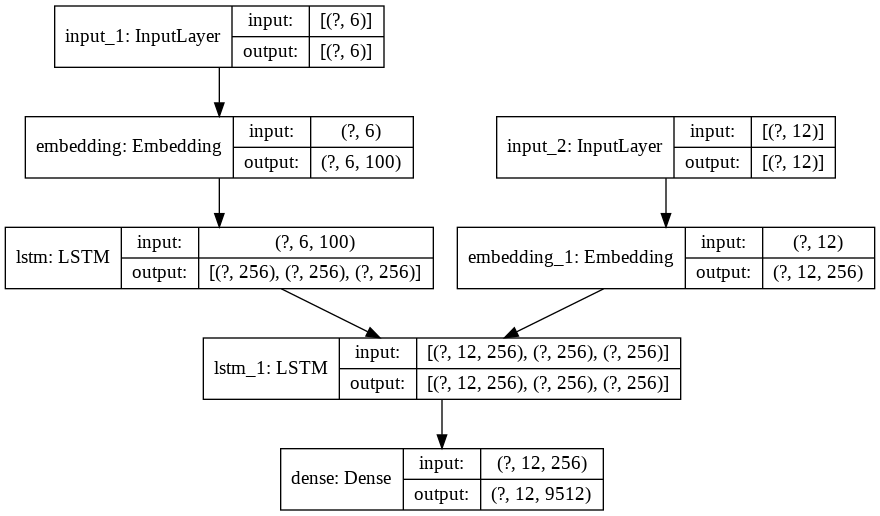

In [94]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

## Train the Model

In [95]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/20
282/282 [==============================] - 204s 722ms/step - loss: 1.9498 - accuracy: 0.7346 - val_loss: 1.6721 - val_accuracy: 0.7720
Epoch 2/20
282/282 [==============================] - 204s 722ms/step - loss: 1.0923 - accuracy: 0.8520 - val_loss: 1.2239 - val_accuracy: 0.8443
Epoch 3/20
282/282 [==============================] - 203s 718ms/step - loss: 0.8389 - accuracy: 0.8901 - val_loss: 1.0512 - val_accuracy: 0.8721
Epoch 4/20
282/282 [==============================] - 200s 711ms/step - loss: 0.7108 - accuracy: 0.9079 - val_loss: 0.9557 - val_accuracy: 0.8875
Epoch 5/20
282/282 [==============================] - 196s 697ms/step - loss: 0.6284 - accuracy: 0.9197 - val_loss: 0.8956 - val_accuracy: 0.8983
Epoch 6/20
282/282 [==============================] - 191s 679ms/step - loss: 0.5663 - accuracy: 0.9289 - val_loss: 0.8530 - val_accuracy: 0.9058
Epoch 7/20
282/282 [==============================] - 191s 677ms/step - loss: 0.5249 - accuracy: 0.9353 - val_loss: 0.8281 -

Suppose we have a sentence i'm ill. The sentence is translated as follows:

// Inputs on the left of Encoder/Decoder, outputs on the right.

Step 1:
I'm ill -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> je + dec(h1,c1)

step 2:

enc(h1,c1) + je -> Decoder -> suis + dec(h2,c2)

step 3:

enc(h2,c2) + suis -> Decoder -> malade. + dec(h3,c3)

step 3:

enc(h3,c3) + malade. -> Decoder -> <eos> + dec(h4,c4)

In [103]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [104]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

 there will be only single word in the decoder input, we need to modify the decoder embedding layer as follows:

In [105]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

 create the placeholder for decoder outputs:

In [106]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

To make predictions, the decoder output is passed through the dense layer:

In [107]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

Update Decoder Model

In [108]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

# plot our modified decoder LSTM that makes predictions

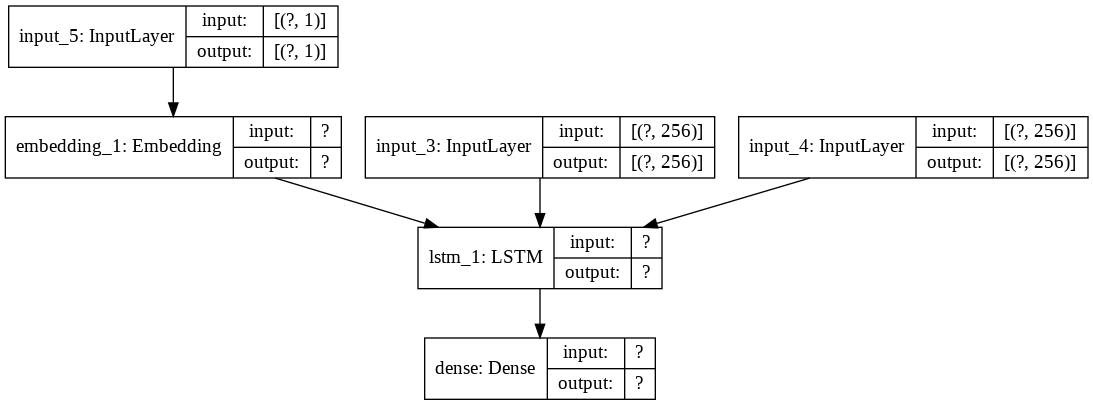

In [109]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In the image above lstm_2 is the modified decoder LSTM. You can see that it accepts the sentence with with one word as shown in input_5, and the hidden and cell states from the previous output (input_3 and input_4). You can see that the shape of the of the input sentence is now (none,1) since there will be only one word in the decoder input. On the contrary, during training the shape of the input sentence was (None,6) since the input contained a complete sentence with a maximum length of 6.

# Making Predictions

In the tokenization steps, we converted words to integers. The outputs from the decoder will also be integers. However, we want our output to be a sequence of words in the French language. To do so, we need to convert the integers back to words. We will create new dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words.

In [110]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

Create a method translate_sentence(). 

The method will accept an input-padded sequence English sentence (in the integer form) and will return the translated French sentence

In [111]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

# Testing the Model

To test the code, we will randomly choose a sentence from the input_sentences list, retrieve the corresponding padded sequence for the sentence, and will pass it to the translate_sentence() method

In [114]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: I am cooking now.
Response: <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> aussi aussi aussi
